# Exploring confinment measures
inspired by http://epidemicforecasting.org/containment

This project aims to be linked to the covid-Mobility project: assessing impacts of policies on mobility

input : https://storage.googleapis.com/static-covid/Containment%20measures/countermeasures_db_johnshopkins.csv as df_raw

see details on the dataset here: https://www.notion.so/Tag-hierarchy-Features-db9799312efa4f88851e8d49393bbb16

## Import Libraries

In [1]:
# data manipulation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# data importation
import requests as re
import json as js
import pyodbc as pyo
import sqlalchemy as sql
from sqlalchemy import create_engine

## Load data and Preprocessing

#### load data

In [31]:
# import dataset from http://epidemicforecasting.org/containment
url = 'https://storage.googleapis.com/static-covid/Containment%20measures/countermeasures_db_johnshopkins.csv'
df_raw=pd.read_csv(url, index_col = 0)

# change date type
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# use dates as index; measures and country as columns; fill NaN values
df_raw = df_raw.pivot(index = 'Date', columns = 'Country').fillna(0)

# adopt names from rest_countries
names_to_change = {'Czechia' : 'Czech Republic',
                   'Iran' : 'Iran (Islamic Republic of)',
                   'Moldova' : 'Moldova (Republic of)',
                   'Russia' : 'Russian Federation',
                   'South Korea' : 'Korea (Republic of)',
                   'United Kingdom' : 'United Kingdom of Great Britain and Northern Ireland'}
df_raw.rename(level = 1, columns = names_to_change, inplace = True)
df_raw.rename_axis(('Measure','Country'),axis=1, inplace = True)
df_raw.tail()

Measure    Symptomatic isolation - targeted                                    \
Country                             Albania Andorra Australia Austria Belarus   
Date                                                                            
2020-04-01                              0.0     0.0       0.0     0.0     0.0   
2020-04-02                              0.0     0.0       0.0     0.0     0.0   
2020-04-03                              0.0     0.0       0.0     0.0     0.0   
2020-04-04                              0.0     0.0       0.0     0.0     0.0   
2020-04-05                              0.0     0.0       0.0     0.0     0.0   

Measure                                                          ...  \
Country    Belgium Bosnia and Herzegovina Bulgaria Canada China  ...   
Date                                                             ...   
2020-04-01     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-02     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-03     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-04     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-05     0.0                    0.0      0.0    1.0   0.0  ...   

Measure          Deaths                                                       \
Country    South Africa Korea (Republic of)  Spain Sweden Switzerland Taiwan   
Date                                                                           
2020-04-01            5                 165   9387    239         488      5   
2020-04-02            5                 169  10348    308         536      5   
2020-04-03            9                 174  11198    358         591      5   
2020-04-04            9                 177  11947    373         666      5   
2020-04-05           11                 183  12641    401         715      5   

Measure                           \
Country    Turkey Uganda Ukraine   
Date                               
2020-04-01    277      0      20   
2020-04-02    356      0      22   
2020-04-03    425      0      27   
2020-04-04    501      0      32   
2020-04-05    574      0      37   

Measure                                                          
Country    United Kingdom of Great Britain and Northern Ireland  
Date                                                             
2020-04-01                                               2357    
2020-04-02                                               2926    
2020-04-03                                               3611    
2020-04-04                                               4320    
2020-04-05                                               4943    

[5 rows x 1664 columns]

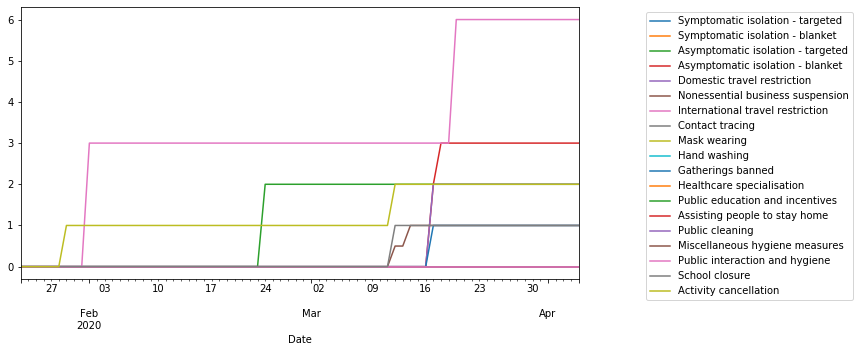

In [32]:
# select relevant policicies/measures expected to have an impact on mobility
df_measures = df_raw.drop(['Deaths',
                           'Confirmed Cases',
                           'Testing',
                           'Resumption',
                           'Diagnostic criteria loosened',
                           'Diagnostic criteria tightened',
                           'Testing criteria'],
                           axis = 1,
                           level = 0)

# show example with Belgium
plt.rcParams['figure.figsize'] = [10, 5]
df_measures.xs('Belgium',level=1,axis=1).plot(legend = None)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

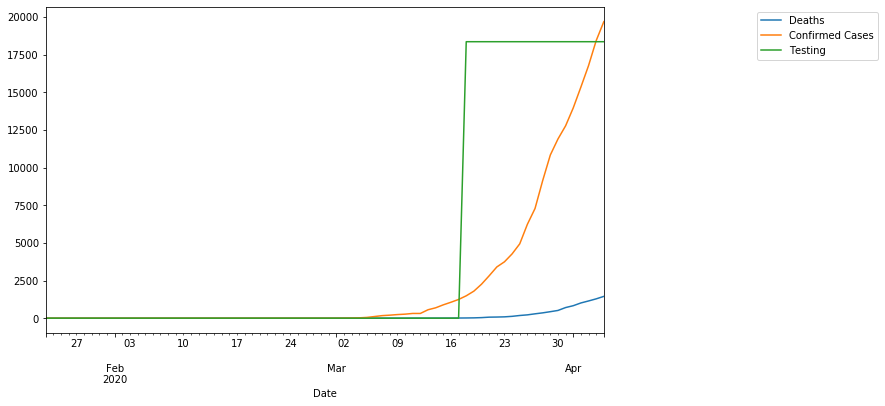

In [33]:
# select number of cases
df_cases = df_raw[['Deaths','Confirmed Cases','Testing']]

# show example with Belgium
plt.rcParams['figure.figsize'] = [10, 6]
df_cases.xs('Belgium',level=1,axis=1).plot(legend = None)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

hereunder, I shall create a new df with countries as columns, measure as index, date of measure (separating level 1, level 2 as different measures) as values

In [38]:
measures = list(df_measures.groupby('Measure', axis=1).min().columns.get_level_values('Measure'))
countries = list(df_measures.groupby('Country',axis=1).min().columns.get_level_values('Country'))

In [37]:
df_measures

Measure    Symptomatic isolation - targeted                                    \
Country                             Albania Andorra Australia Austria Belarus   
Date                                                                            
2020-01-23                              0.0     0.0       0.0     0.0     0.0   
2020-01-24                              0.0     0.0       0.0     0.0     0.0   
2020-01-25                              0.0     0.0       0.0     0.0     0.0   
2020-01-26                              0.0     0.0       0.0     0.0     0.0   
2020-01-27                              0.0     0.0       0.0     0.0     0.0   
...                                     ...     ...       ...     ...     ...   
2020-04-01                              0.0     0.0       0.0     0.0     0.0   
2020-04-02                              0.0     0.0       0.0     0.0     0.0   
2020-04-03                              0.0     0.0       0.0     0.0     0.0   
2020-04-04                              0.0     0.0       0.0     0.0     0.0   
2020-04-05                              0.0     0.0       0.0     0.0     0.0   

Measure                                                          ...  \
Country    Belgium Bosnia and Herzegovina Bulgaria Canada China  ...   
Date                                                             ...   
2020-01-23     0.0                    0.0      0.0    0.0   0.0  ...   
2020-01-24     0.0                    0.0      0.0    0.0   0.0  ...   
2020-01-25     0.0                    0.0      0.0    0.0   0.0  ...   
2020-01-26     0.0                    0.0      0.0    0.0   0.0  ...   
2020-01-27     0.0                    0.0      0.0    0.0   0.0  ...   
...            ...                    ...      ...    ...   ...  ...   
2020-04-01     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-02     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-03     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-04     0.0                    0.0      0.0    1.0   0.0  ...   
2020-04-05     0.0                    0.0      0.0    1.0   0.0  ...   

Measure    Activity cancellation                                               \
Country             South Africa Korea (Republic of) Spain Sweden Switzerland   
Date                                                                            
2020-01-23                   0.0                 0.0   0.0    0.0         0.0   
2020-01-24                   0.0                 0.0   0.0    0.0         0.0   
2020-01-25                   0.0                 0.0   0.0    0.0         0.0   
2020-01-26                   0.0                 0.0   0.0    0.0         0.0   
2020-01-27                   0.0                 0.0   0.0    0.0         0.0   
...                          ...                 ...   ...    ...         ...   
2020-04-01                   0.0                 2.0   3.0    0.0         0.0   
2020-04-02                   0.0                 2.0   3.0    0.0         0.0   
2020-04-03                   0.0                 2.0   3.0    0.0         0.0   
2020-04-04                   0.0                 2.0   3.0    0.0         0.0   
2020-04-05                   0.0                 2.0   3.0    0.0         0.0   

Measure                                  \
Country    Taiwan Turkey Uganda Ukraine   
Date                                      
2020-01-23    0.0    0.0    0.0     0.0   
2020-01-24    0.0    0.0    0.0     0.0   
2020-01-25    0.0    0.0    0.0     0.0   
2020-01-26    0.0    0.0    0.0     0.0   
2020-01-27    0.0    0.0    0.0     0.0   
...           ...    ...    ...     ...   
2020-04-01    0.0    3.0    3.0     3.0   
2020-04-02    0.0    3.0    3.0     3.0   
2020-04-03    0.0    3.0    3.0     3.0   
2020-04-04    0.0    3.0    3.0     3.0   
2020-04-05    0.0    3.0    3.0     3.0   

Measure                                                          
Country    United Kingdom of Great Britain and North

In [89]:
# donc là je crée un espace de n_measures dimensions (en séparant les niveaux différents) qui contiennent en coordonnées 
# les dates auxquelles la mesure a été prise. 
df_change = pd.DataFrame()#columns = countries, index = measures)

for column in df_measures.columns:
    date_of_change = list(df_measures[df_measures[column] != df_measures[column].shift(1)].index.dayofyear.astype('float'))
    try: #there is at least one change
        date_of_change = list(np.array(date_of_change[1:]) - min(date_of_change))

        count = 0
        for date in date_of_change:
            df_change.loc[column[0] + ', ' + str(count),column[1]] = date_of_change[count]
            count += 1
            
    except: #there is no change : stays 0 all the time
        print(column, len(date_of_change))
        
df_change.sort_index(inplace = True)  
df_change

,Canada,Czech Republic,Hungary,Netherlands,Singapore,United Kingdom of Great Britain and Northern Ireland,Belgium,China,Egypt,Hong Kong,...,Georgia,Latvia,Romania,Russian Federation,Sweden,Taiwan,Uganda,Iran (Islamic Republic of),Monaco,Morocco
"Activity cancellation, 0",NaN,42.0,44.0,NaN,15.0,NaN,6.0,9.0,54.0,15.0,...,NaN,NaN,36.0,54.0,NaN,NaN,57.0,53.0,NaN,NaN
"Activity cancellation, 1",NaN,51.0,53.0,NaN,23.0,NaN,49.0,18.0,56.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Activity cancellation, 2",NaN,NaN,NaN,NaN,50.0,NaN,NaN,22.0,58.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Activity cancellation, 3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Activity cancellation, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Activity cancellation, 5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Assisting people to stay home, 0",NaN,NaN,56.0,60.0,4.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,48.0,56.0,NaN,NaN,NaN,NaN
"Assisting people to stay home, 1",NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Assisting people to stay home, 2",NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Asymptomatic isolation - blanket, 0",NaN,NaN,NaN,60.0,4.0,60.0,54.0,9.0,NaN,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### wow, this ain't sexy. 
we could aggregate these values :
- per country, count(values) (how many measures has the country taken... hem);
- per country, sort of sum(values): for how many policy-days has the country undergone (1 policy during 2 days considered equivalent to 2 policies during 1 day) (this of course means that the first countries to react will tend to have higher values)

,Albania,Andorra,Australia,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Canada,China,...,Slovenia,South Africa,Spain,Sweden,Switzerland,Taiwan,Turkey,Uganda,Ukraine,United Kingdom of Great Britain and Northern Ireland
Number,17.0,2.0,4.0,8.0,NaN,12.0,11.0,6.0,3.0,18.0,...,8.0,3.0,11.0,4.0,5.0,7.0,4.0,6.0,5.0,5.0
Amount,424.0,43.0,122.0,179.0,NaN,357.0,224.0,142.0,72.0,999.0,...,172.0,49.0,304.0,87.0,126.0,327.0,76.0,142.0,100.0,100.0


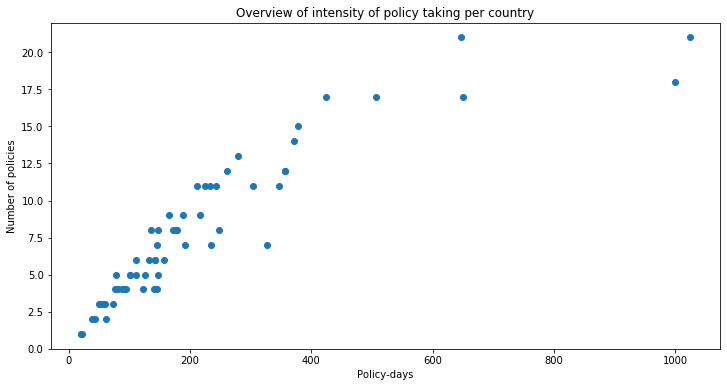

In [150]:
# aggregation
df_change_agg = pd.DataFrame(columns = countries)
df_change_agg.loc['Number'] = df_change.count()
df_change_agg.loc['Amount'] = ((df_raw.index.dayofyear - min(df_raw.index.dayofyear)).max() - df_change).sum()

# visualisation
plt.figure(figsize=(12,6))
plt.plot(df_change_agg.loc['Amount'], df_change_agg.loc['Number'], 'o')
plt.title("Overview of intensity of policy taking per country")
plt.xlabel("Policy-days")
plt.ylabel("Number of policies")

df_change_agg

In [173]:
#df_change.transpose().count().sort_values()
#df_change_agg.loc['Number'].sort_values()
df_change_agg.transpose()[df_change_agg.loc['Number']>=5].transpose()

,Albania,Austria,Belgium,Bosnia and Herzegovina,Bulgaria,China,Croatia,Cyprus,Czech Republic,Denmark,...,Serbia,Singapore,Slovakia,Slovenia,Spain,Switzerland,Taiwan,Uganda,Ukraine,United Kingdom of Great Britain and Northern Ireland
Number,17.0,8.0,12.0,11.0,6.0,18.0,13.0,5.0,17.0,11.0,...,6.0,21.0,11.0,8.0,11.0,5.0,7.0,6.0,5.0,5.0
Amount,424.0,179.0,357.0,224.0,142.0,999.0,279.0,78.0,506.0,243.0,...,110.0,1024.0,212.0,172.0,304.0,126.0,327.0,142.0,100.0,100.0


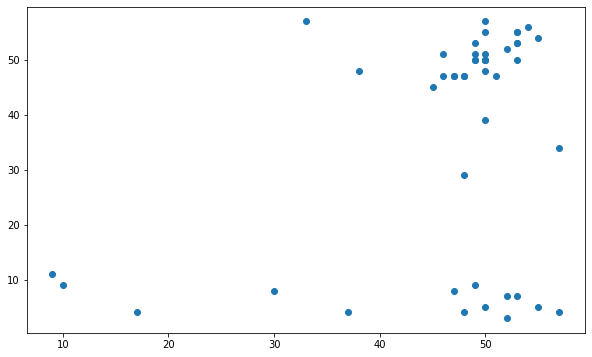

In [148]:
plt.plot(df_change.loc['School closure, 0'], df_change.loc['International travel restriction, 0'], 'o')

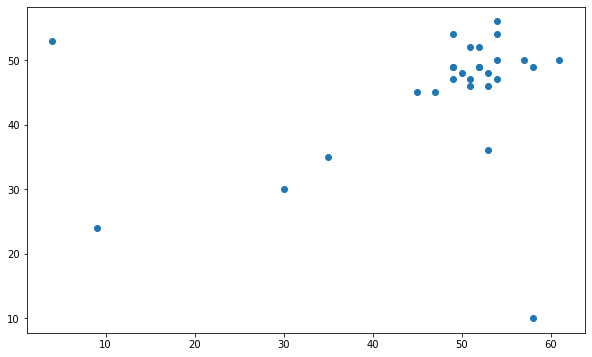

In [149]:
plt.plot(df_change.loc['Nonessential business suspension, 0'], df_change.loc['Gatherings banned, 0'], 'o')

# alright so now the idea is to cluster that. Select only countries with count(policies) > 5 (all others in the same cluster?) ? Select only features with count(countries) > 5 ?
and which method should I use : https://scikit-learn.org/stable/modules/clustering.html#clustering
or Partial data cluster analysis from https://www.displayr.com/5-ways-deal-missing-data-cluster-analysis/?utm_content=buffer11236&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer